In [ ]:
from google.colab import files

# This will open a file chooser to upload your CSV
uploaded = files.upload()


Saving diabetes.csv to diabetes.csv


In [ ]:
# Necessary imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# Load data
df = pd.read_csv('diabetes.csv')

# Quick look at data
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [ ]:
df.describe()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


In [ ]:
# Info and missing values
df.info()
print("Any missing values?", df.isnull().values.any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB
Any missing values? False


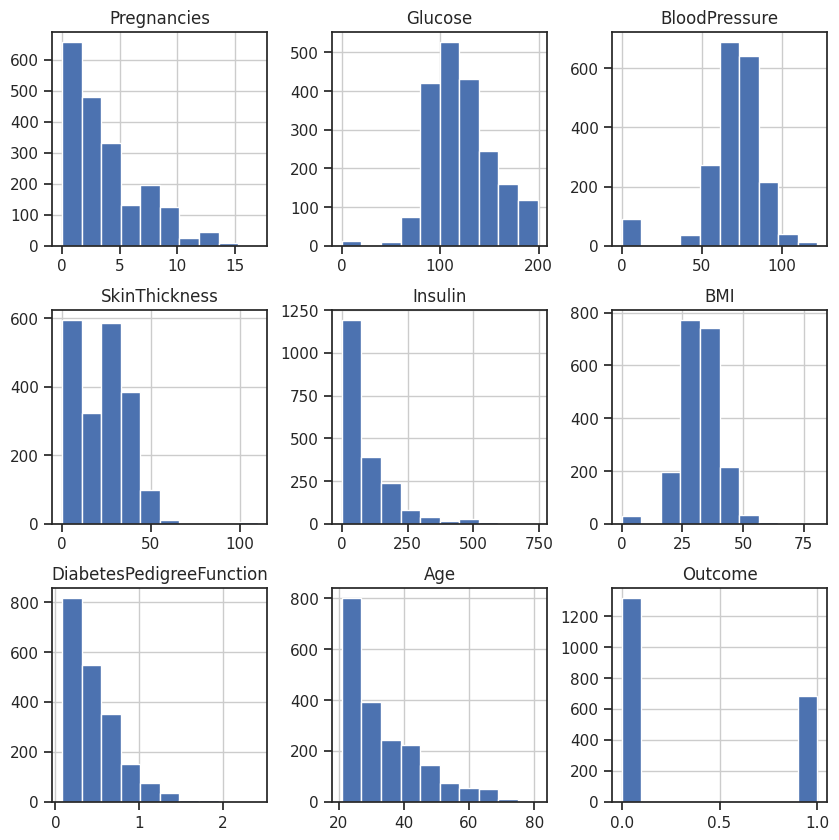

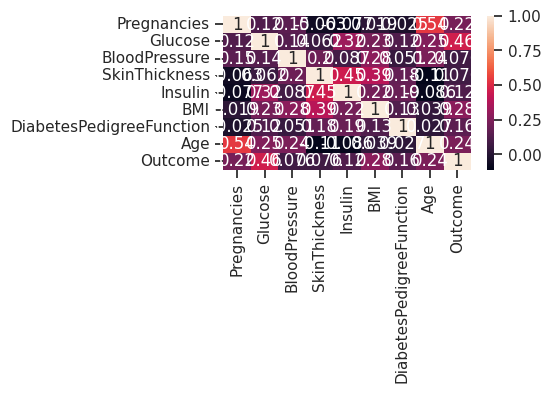

/tmp/ipython-input-1808115649.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Outcome'], palette='Set1')


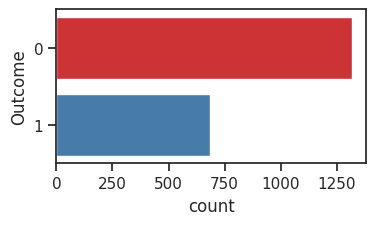

In [ ]:
# Histograms
df.hist(bins=10, figsize=(10,10))
plt.show()

# Correlation heatmap
sns.heatmap(df.corr(), annot=True)
plt.show()

# Outcome counts
sns.countplot(y=df['Outcome'], palette='Set1')
plt.show()


In [ ]:
# Outlier removal using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df_out = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape, df_out.shape


((2000, 9), (1652, 9))

In [ ]:
# Features and target
X = df_out.drop(columns=['Outcome'])
y = df_out['Outcome']

# Train-test split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_X.shape, test_X.shape, train_y.shape, test_y.shape


((1321, 8), (331, 8), (1321,), (331,))

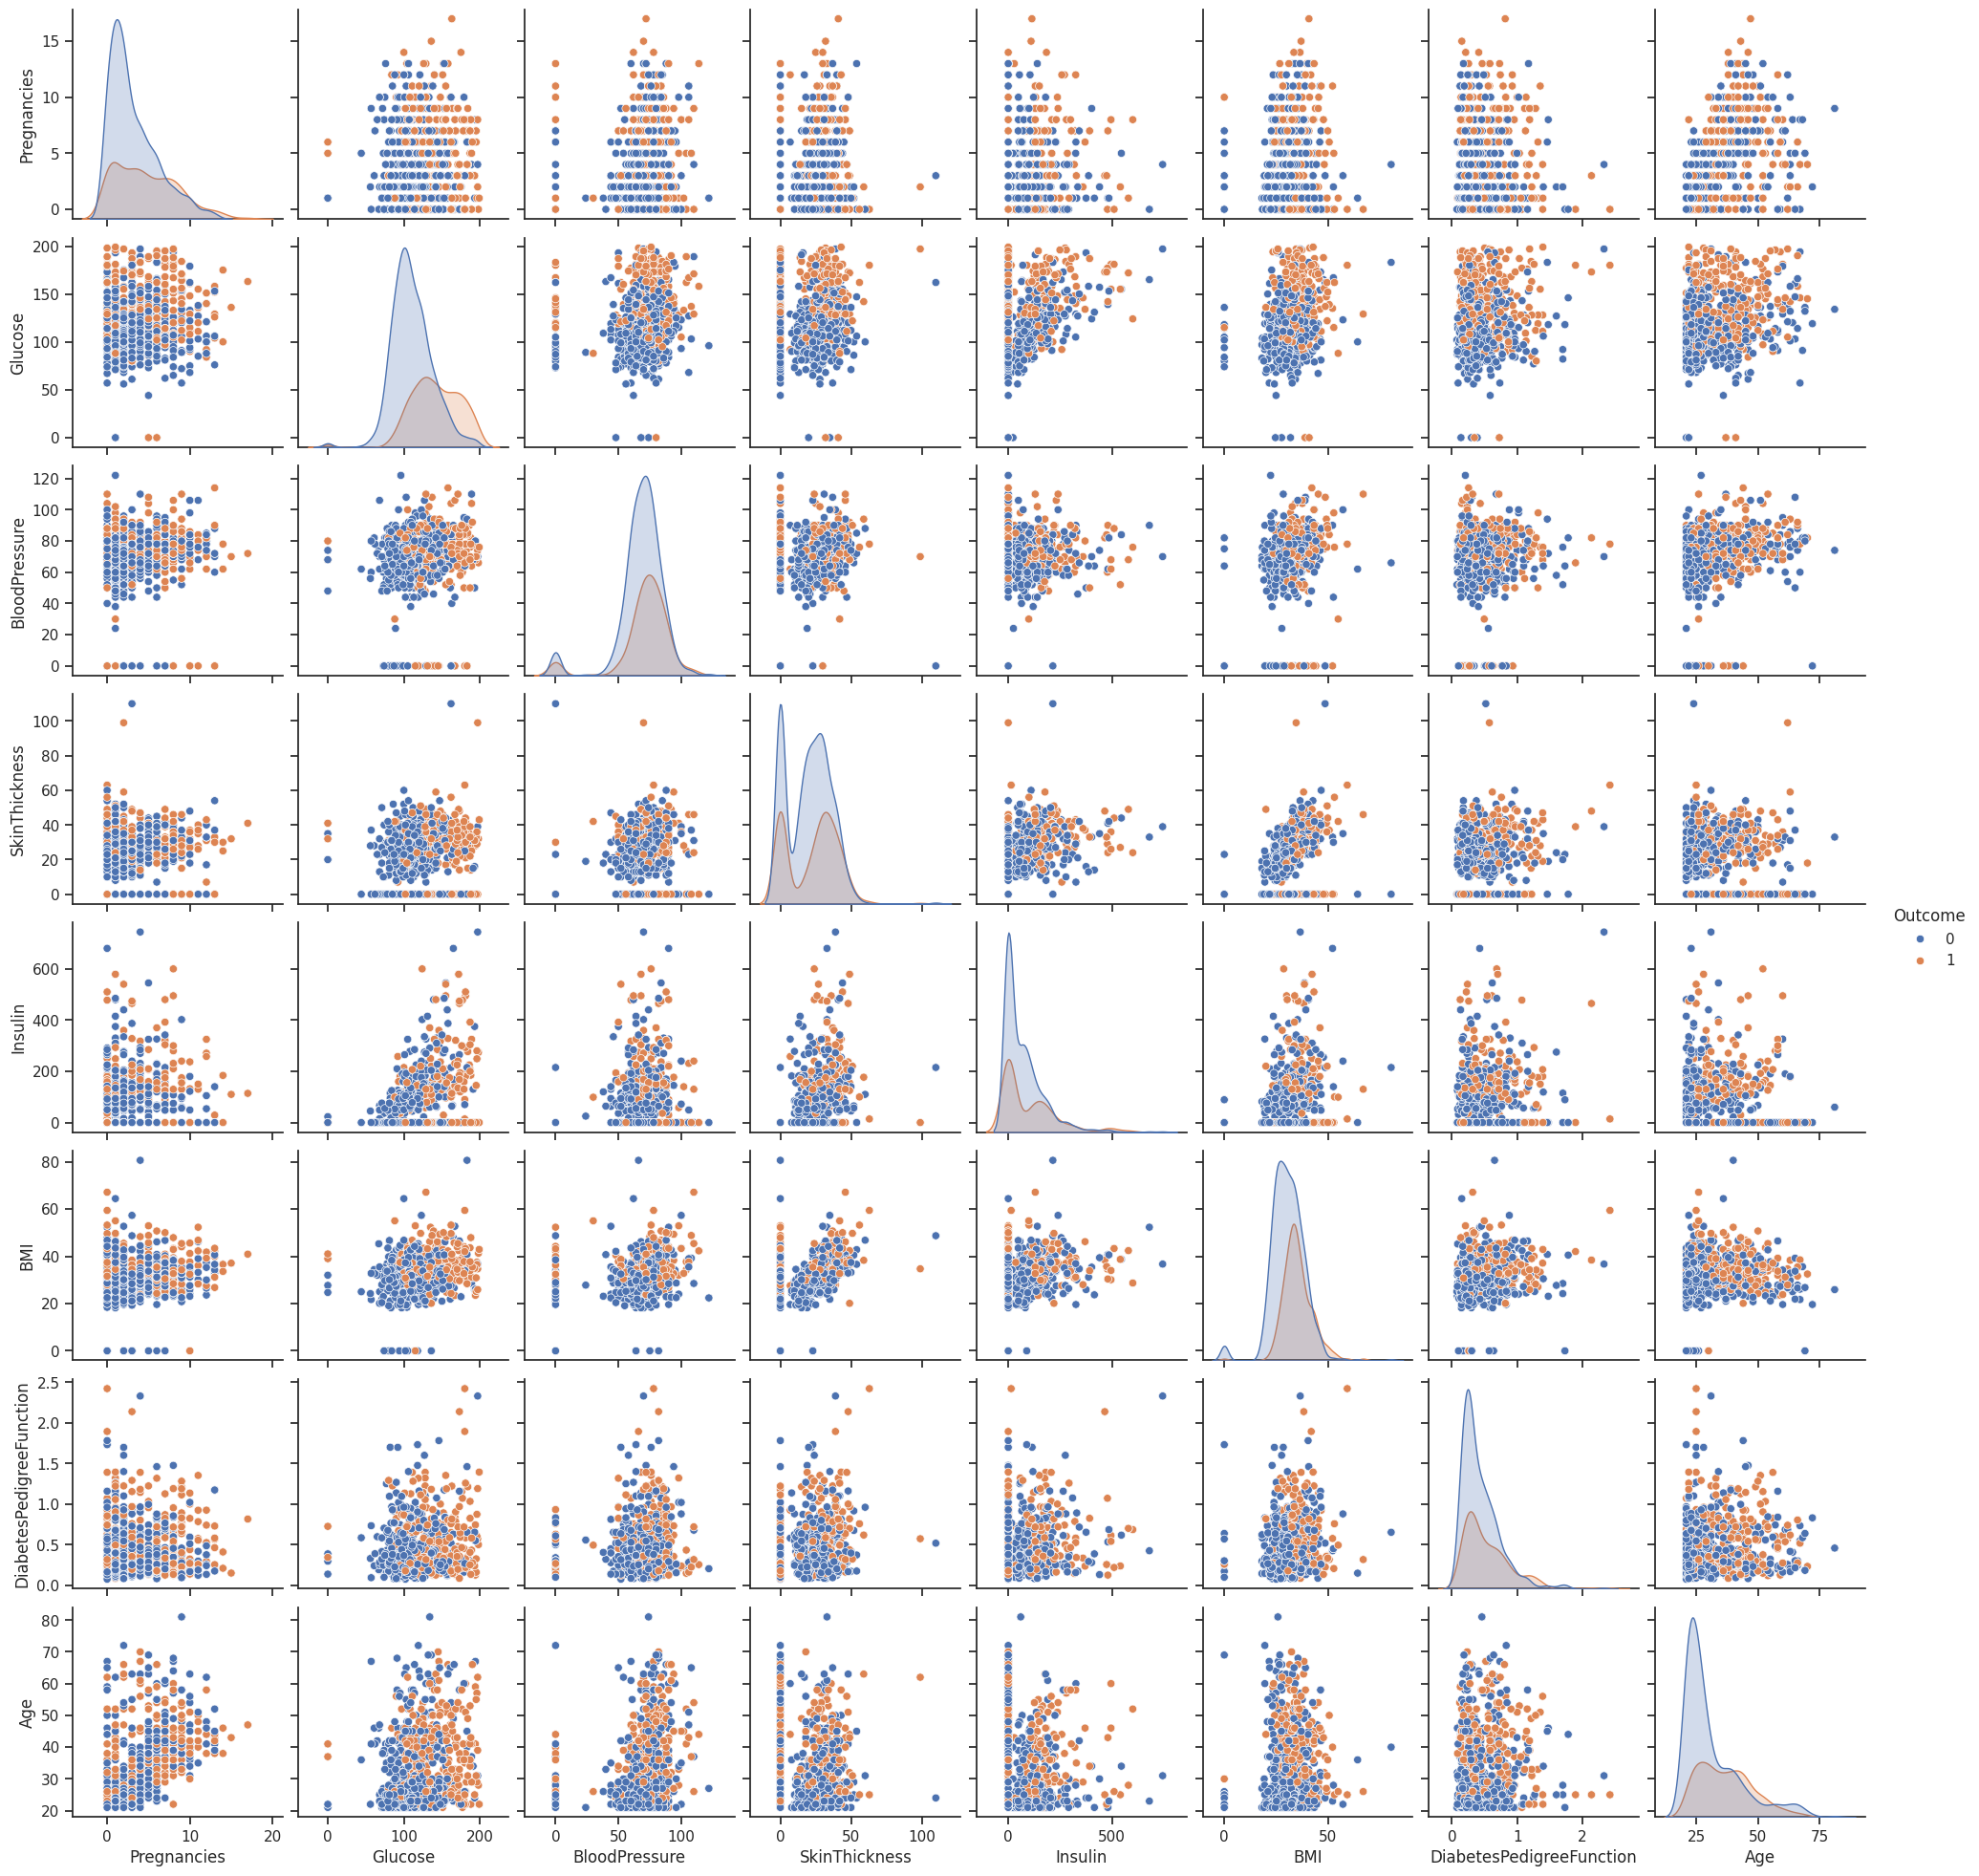

In [ ]:
sns.set(style="ticks")
sns.pairplot(df, hue="Outcome")

In [ ]:
# Functions for cross-validation metrics
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0,0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0,1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1,0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1,1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

def display_result(result):
    print("TP:", result['test_tp'])
    print("TN:", result['test_tn'])
    print("FP:", result['test_fp'])
    print("FN:", result['test_fn'])


In [ ]:
# Models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear'),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, learning_rate=0.2)
}

# Train, predict and evaluate
acc, roc = [], []

for name, clf in models.items():
    clf.fit(train_X, train_y)
    y_pred = clf.predict(test_X)

    ac = accuracy_score(test_y, y_pred)
    rc = roc_auc_score(test_y, y_pred)
    acc.append(ac)
    roc.append(rc)

    print(f"{name} -> Accuracy: {ac:.2f}, ROC AUC: {rc:.2f}")

    result = cross_validate(clf, train_X, train_y, scoring=scoring, cv=10)
    display_result(result)


Logistic Regression -> Accuracy: 0.78, ROC AUC: 0.72
TP: [24 19 23 21 15 22 21 25 18 18]
TN: [84 79 80 77 83 85 89 85 87 84]
FP: [ 8 12 11 14  8  7  3  7  5  8]
FN: [17 22 18 20 26 18 19 15 22 22]
SVM -> Accuracy: 0.79, ROC AUC: 0.72
TP: [24 19 23 19 15 22 21 24 18 19]
TN: [84 82 81 79 83 85 89 85 87 85]
FP: [ 8  9 10 12  8  7  3  7  5  7]
FN: [17 22 18 22 26 18 19 16 22 21]
KNN -> Accuracy: 0.85, ROC AUC: 0.83
TP: [38 30 26 27 28 29 34 33 28 26]
TN: [83 81 83 79 81 82 88 82 86 82]
FP: [ 9 10  8 12 10 10  4 10  6 10]
FN: [ 3 11 15 14 13 11  6  7 12 14]
Random Forest -> Accuracy: 1.00, ROC AUC: 1.00
TP: [38 38 41 36 36 37 40 38 39 39]
TN: [90 87 88 88 89 89 90 92 91 91]
FP: [2 4 3 3 2 3 2 0 1 1]
FN: [3 3 0 5 5 3 0 2 1 1]
Naive Bayes -> Accuracy: 0.74, ROC AUC: 0.70
TP: [27 25 31 23 20 26 23 28 26 21]
TN: [81 74 78 71 76 76 82 78 82 76]
FP: [11 17 13 20 15 16 10 14 10 16]
FN: [14 16 10 18 21 14 17 12 14 19]
Gradient Boosting -> Accuracy: 0.89, ROC AUC: 0.86
TP: [32 31 30 26 29 30 27 32 3

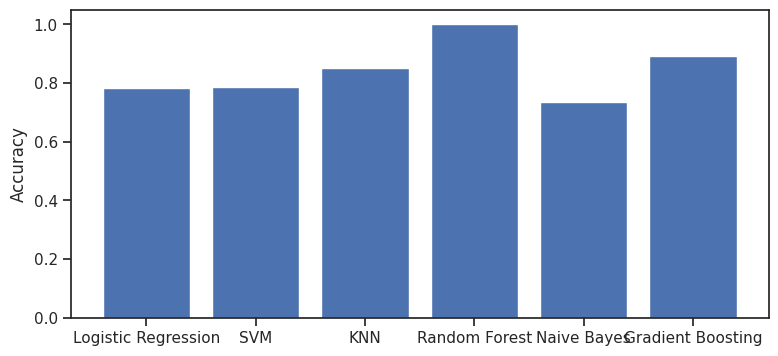

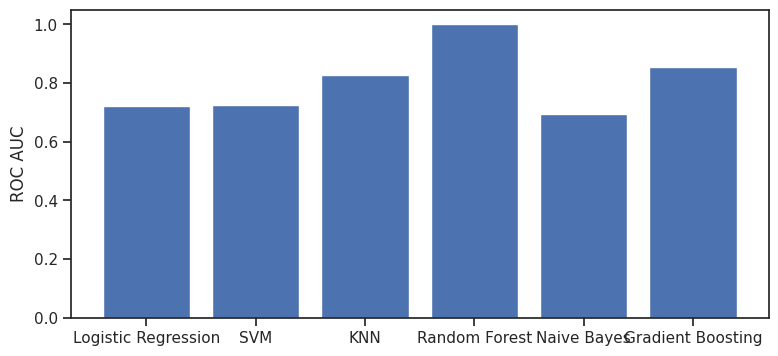

In [ ]:
# Accuracy comparison
plt.figure(figsize=(9,4))
plt.bar(models.keys(), acc)
plt.ylabel('Accuracy')
plt.show()

# ROC AUC comparison
plt.figure(figsize=(9,4))
plt.bar(models.keys(), roc)
plt.ylabel('ROC AUC')
plt.show()
